# Final Project Phase 3 Summary
This Jupyter Notebook (.ipynb) will serve as the skeleton file for your submission for Phase 3 of the Final Project. Complete all sections below as specified in the instructions for the project, covering all necessary details. We will use this to grade your individual code (Do this whether you are in a group or not). Good luck! <br><br>

Note: To edit a Markdown cell, double-click on its text.

## Jupyter Notebook Quick Tips
Here are some quick formatting tips to get you started with Jupyter Notebooks. This is by no means exhaustive, and there are plenty of articles to highlight other things that can be done. We recommend using HTML syntax for Markdown but there is also Markdown syntax that is more streamlined and might be preferable. 
<a href = "https://towardsdatascience.com/markdown-cells-jupyter-notebook-d3bea8416671">Here's an article</a> that goes into more detail. (Double-click on cell to see syntax)

# Heading 1
## Heading 2
### Heading 3
#### Heading 4
<br>
<b>BoldText</b> or <i>ItalicText</i>
<br> <br>
Math Formulas: $x^2 + y^2 = 1$
<br> <br>
Line Breaks are done using br enclosed in < >.
<br><br>
Hyperlinks are done with: <a> https://www.google.com </a> or 
<a href="http://www.google.com">Google</a><br>

# Data Collection and Cleaning


Transfer/update the data collection and cleaning you created for Phase II below. You may include additional cleaning functions if you have extra datasets. If no changes are necessary, simply copy and paste your phase II parsing/cleaning functions.


In [ ]:
import csv
import pandas as pd
import numpy as np
from pprint import pprint
import requests
from bs4 import BeautifulSoup
import json 
import re

### Visualization imports ###
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, Dropdown
from IPython.display import display, clear_output
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

## Downloaded Dataset Requirement



In [ ]:
# No changes were made from phase II
# opens the downloaded dataset, fills in missing team name data, drops all but one row per game,
# creates a column showing who won each game, and adds a column representing how many games the winning team has won in total.
def game_logCleaner():
  # opens a csv file with each row corresponding to player fantasy football data as well as game information for each game from 2019-2023
  # source: 'https://www.advancedsportsanalytics.com/nfl-raw-data'
  with open('nfl_pass_rush_receive_raw_data.csv') as f:
    reader = csv.reader(f)
    reader_list = list(reader)
    
    df = pd.DataFrame(reader_list, columns = reader_list[0])

    # if home_team != team, set equal to team
    # if home_team == team, drop the row since we already have the data for that game in another row
    #### Note: there are no instances where home_team and vis_team are both 'Error' ####
    df['vis_team'] = np.where((df['vis_team'] != 'ERROR - abbrev_team'), df['vis_team'], np.where(df['home_team'] != df['team'], df['team'], 0))
    # we only need one row per game, so we do not need to deal with these
    df = df[(df['vis_team'] != 0) & (df['vis_team'] != 'ERROR - abbrev_team')]
    
    # do the same for home_team
    
    # if vis_team != team, set equal to team
    # if vis_team == team, drop the row
    df['home_team'] = np.where((df['home_team'] != 'ERROR - abbrev_team'), df['home_team'], np.where(df['vis_team'] != df['team'], df['team'], 0))
    # we only need one row per game, so there is no need to deal with these
    df = df[(df['home_team'] != 0) & (df['home_team'] != 'ERROR - abbrev_team')]
    
    df = df.groupby('game_id').first()
    # for some reason the last row was a repeat of the column titles
    df = df.iloc[:-1]
    
    df['winning_team']  = np.where(df['home_score'].astype(int) > df['vis_score'].astype(int), df['home_team'], df['vis_team'])
    df = df[['game_date', 'vis_team', 'home_team', 'vis_score', 'home_score', 'winning_team']]
    
    # count the number of games each team has won. This shows the number of teams the team in the 'winning_team' column has.
    df['team_win_total'] = df['winning_team'].apply(lambda x: (x==df['winning_team']).sum())

    pprint(df)
    
    # write to a csv. Only has one sheet, so no need for xlsx file
    df.to_csv('clean_gameLog.csv', index = True)
    print('done')
        



############ Function Call ############
game_logCleaner()

             game_date vis_team home_team vis_score home_score winning_team  \
game_id                                                                       
201909050chi  9/5/2019      GNB       CHI        10          3          GNB   
201909080car  9/8/2019      LAR       CAR        30         27          LAR   
201909080cle  9/8/2019      TEN       CLE        43         13          TEN   
201909080crd  9/8/2019      DET       ARI        27         27          DET   
201909080dal  9/8/2019      NYG       DAL        17         35          DAL   
...                ...      ...       ...       ...        ...          ...   
202301080phi  1/8/2023      NYG       PHI        16         22          PHI   
202301080pit  1/8/2023      CLE       PIT        14         28          PIT   
202301080sea  1/8/2023      LAR       SEA        16         19          SEA   
202301080sfo  1/8/2023      ARI       SFO        13         38          SFO   
202301080was  1/8/2023      DAL       WAS         6 

## Web Collection Requirement \#1


In [ ]:
# The only change from phase II is that we added a 'position' column.
# returns a cleaned dataset with the combine performance of each athlete from all 
# the interested football positions ['QB', 'WR', 'RB','OLB', 'ILB','SS'] which later be will
# used in Phase 3 to calculate and visualize the combine score
def clean_combine():
  # These are the only player positions we will be tracking the combine performance for
  positions = ['QB', 'WR', 'RB','OLB', 'ILB','SS']
  data = {}

  for position in positions:
    # source: 'https://nflcombineresults.com/nflcombinedata.php'
    # performs a get request to the appropriate URL containing the specified position and creates a BeautifulSoup object from that HTML site
    response = requests.get(f"https://nflcombineresults.com/nflcombinedata.php?year=2018&pos={position}&college=")
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table', {"class": "sortable"})

    for table_row in table.find_all('tr', {"class": "tablefont"}):
      row = [table_data.text.strip() for table_data in table_row.find_all('td')]
      
      player_name = row[1]

      player_stats = {
          # players whose positions listed are 'OLB' or 'ILB' are stored as 'LB' and 'SS' so that it matches the position labels from the api dataset 
          # all other positions in dictionary are the same as the one listed on each site
          "Position": 'S' if position == 'SS' else 'LB' if position == 'OLB' or position == 'ILB' else position,

          # cleans data set when a metric for a player's combine performance is missing from the website by storing the metric value as None in the dataset
          "40 Yard Dash": float(row[7].strip()) if row[7].strip() != '' else None,
          "Vertical Leap": float(row[9].strip()) if row[9].strip() != '' else None,
          "Broad Jump": float(row[10].strip()) if row[10].strip() != '' else None,
          "Shuttle": float(row[11].strip()) if row[11].strip() != '' else None,
          "3Cone": float(row[12].strip()) if row[12].strip() != '' else None,
          "Bench Press": float(row[8].strip()) if row[8].strip() != '' else None
        }

      # player who do not have data avaiable for their 40 Yard Dash, Vertical Leap, Broad Jump, Shuttle, and 3Cone (all of them are None) are not added to the dataset
      if player_stats["40 Yard Dash"] != None or player_stats["Vertical Leap"] != None or player_stats["Broad Jump"] != None or player_stats["Broad Jump"] != None or player_stats["3Cone"] != None:
        data[player_name] = player_stats

      
  # writes cleaned web scraped data of all players combined performance into a csv that is one sheet long
  with open('clean_combine_data.csv', mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Name', 'position', '40 Yard Dash', 'Vertical Leap', 'Broad Jump', 'Shuttle', '3Cone', 'Bench Press'])
        for name, stats in data.items():
            writer.writerow([name, stats.get('Position'), stats.get('40 Yard Dash'), stats.get('Vertical Leap'), stats.get('Broad Jump'), stats.get('Shuttle'), stats.get('3Cone'), stats.get('Bench Press')])

  # outputs the data in Jupyter Notebook
  return data

############ Function Call ############
clean_combine()

{'Austin Allen': {'Position': 'QB',
  '40 Yard Dash': 4.81,
  'Vertical Leap': 29.5,
  'Broad Jump': 112.0,
  'Shuttle': 4.48,
  '3Cone': 7.18,
  'Bench Press': None},
 'Josh Allen': {'Position': 'QB',
  '40 Yard Dash': 4.75,
  'Vertical Leap': 33.5,
  'Broad Jump': 119.0,
  'Shuttle': 4.4,
  '3Cone': 6.9,
  'Bench Press': None},
 'Kyle Allen': {'Position': 'QB',
  '40 Yard Dash': 4.71,
  'Vertical Leap': 28.5,
  'Broad Jump': 113.0,
  'Shuttle': 4.26,
  '3Cone': None,
  'Bench Press': None},
 'J.T. Barrett': {'Position': 'QB',
  '40 Yard Dash': 4.7,
  'Vertical Leap': 30.0,
  'Broad Jump': 108.0,
  'Shuttle': 4.44,
  '3Cone': 7.38,
  'Bench Press': None},
 'Kurt Benkert': {'Position': 'QB',
  '40 Yard Dash': 4.95,
  'Vertical Leap': 31.0,
  'Broad Jump': 112.0,
  'Shuttle': 4.33,
  '3Cone': 7.15,
  'Bench Press': 16.0},
 'Max Browne': {'Position': 'QB',
  '40 Yard Dash': 5.1,
  'Vertical Leap': 30.0,
  'Broad Jump': 113.0,
  'Shuttle': 4.57,
  '3Cone': 7.5,
  'Bench Press': 23.0},
 'R

## Web Collection Requirement #2

In [ ]:
# No changes were made from phase II
# gets every player id from the api containing every player id
# then uses the api containing player statistics to match player id's with player names
# returns a list of dictionaries containg every player id as keys and the player name as values
# this list will help us create career scores for the players we are interested in

def get_playerList():
    # source: 'https://sports.core.api.espn.com/v3/sports/football/nfl/athletes?limit=20000' (ESPN Sport Core API Data) 
    # This first url gets us the athlete id's for every active NFL player
    url = 'https://sports.core.api.espn.com/v3/sports/football/nfl/athletes?limit=20000'
    jsonData = requests.get(url).json()
    
    players = pd.DataFrame(jsonData['items']).dropna(subset='firstName')
    players = players[players.active == True]
    
    athlete_id_list = [id_num for id_num in players.id]
    
    # initialize an empty list that will hold a dictionary for every player we are interested in analyzing
    player_list = []
    # These are the only positions we will track
    pos_list = ['QB', 'WR', 'RB','LB','S']
    
    for player_id in athlete_id_list:
        # source: ESPN Web API
        player_url = f'https://site.web.api.espn.com/apis/common/v3/sports/football/nfl/athletes/{player_id}'
        player_response = requests.get(player_url)

        # 2023 rookies do not have a 'debutYear' key yet. We are not interested in these players, so we can just skip pass them
        try:    
            # all relevent data is stored in the 'athlete' key
            player_data = player_response.json()['athlete']
            # initialize an empty dictionary that will contain the data for each player
            player_dict = {}
            player_dict['athleteID'] = player_id
            player_dict['name'] = player_data['fullName']
            
            # since we have the game log for 2019, we want to analyze players who debuted in 2019 to see if they experienced 
            # immediate success. We are also only interested in some positions
            if player_data['debutYear'] == 2018 and player_data['position']['abbreviation'] in pos_list:
                player_dict['position'] = player_data['position']['abbreviation']
                
                # some players went undrafted. These players do not have a 'displayDraft' key
                try:
                    player_dict['draftInfo'] = player_data['displayDraft']
                except:
                    player_dict['draftInfo'] = 'undrafted'
                
                player_dict['team'] = player_data['team']['franchise']['abbreviation']
                # relevent statistics for WRs
                player_dict['receptions'] = player_data['statsSummary']['statistics'][0]['displayValue'] if player_data['position']['abbreviation'] == 'WR' else 0
                player_dict['receiving_yards'] = player_data['statsSummary']['statistics'][1]['displayValue'] if player_data['position']['abbreviation'] == 'WR' else 0
                player_dict['receiving_td'] = player_data['statsSummary']['statistics'][2]['displayValue'] if player_data['position']['abbreviation'] == 'WR' else 0
                  
                # relevent stats for S    
                player_dict['solo_tackles'] = player_data['statsSummary']['statistics'][0]['displayValue'] if player_data['position']['abbreviation'] == 'S' else 0
                player_dict['forced_fumbles'] = player_data['statsSummary']['statistics'][1]['displayValue'] if player_data['position']['abbreviation'] == 'S' else 0
                player_dict['interceptions'] = player_data['statsSummary']['statistics'][2]['displayValue'] if player_data['position']['abbreviation'] == 'S' else 0
                player_dict['passed_defended'] = player_data['statsSummary']['statistics'][3]['displayValue'] if player_data['position']['abbreviation'] == 'S' else 0
                
                # relevent stats for RBs
                player_dict['rush_att'] = player_data['statsSummary']['statistics'][0]['displayValue'] if player_data['position']['abbreviation'] == 'RB' else 0
                player_dict['rush_yds'] = player_data['statsSummary']['statistics'][1]['displayValue'] if player_data['position']['abbreviation'] == 'RB' else 0
                player_dict['rush_td'] = player_data['statsSummary']['statistics'][2]['displayValue'] if player_data['position']['abbreviation'] == 'RB' else 0
                
                # relevent stats for LBs
                player_dict['solo_tackles'] = player_data['statsSummary']['statistics'][0]['displayValue'] if player_data['position']['abbreviation'] == 'LB' else 0
                player_dict['sacks'] = player_data['statsSummary']['statistics'][1]['displayValue'] if player_data['position']['abbreviation'] == 'LB' else 0
                player_dict['forced_fumbles'] = player_data['statsSummary']['statistics'][2]['displayValue'] if player_data['position']['abbreviation'] == 'LB' else 0
                player_dict['interceptions'] = player_data['statsSummary']['statistics'][3]['displayValue'] if player_data['position']['abbreviation'] == 'LB' else 0
                
                # relevent stats for QBs
                player_dict['passing_yards'] = player_data['statsSummary']['statistics'][0]['displayValue'] if player_data['position']['abbreviation'] == 'QB' else 0
                player_dict['passing_td'] = player_data['statsSummary']['statistics'][1]['displayValue'] if player_data['position']['abbreviation'] == 'QB' else 0
                player_dict['interceptions'] = player_data['statsSummary']['statistics'][2]['displayValue'] if player_data['position']['abbreviation'] == 'QB' else 0
                
        except:
            
            continue
            
        player_list.append(player_dict)
        
    df = pd.DataFrame(data = player_list)
    df.set_index('athleteID', inplace = True)
    df.dropna(inplace = True)
    pprint(df)

    # write to a csv. Only has one sheet, so no need for xlsx file
    df.to_csv('clean_playerdata.csv', index = True)
    print('done')
        
        

############ Function Call ############
get_playerList()

                         name position                 draftInfo team  \
athleteID                                                               
3126179         Matthew Adams       LB  2018: Rd 7, Pk 221 (IND)  CLE   
3918298            Josh Allen       QB    2018: Rd 1, Pk 7 (BUF)  BUF   
3115293            Kyle Allen       QB                 undrafted  BUF   
3915507          Jerome Baker       LB   2018: Rd 3, Pk 73 (MIA)  MIA   
3929630        Saquon Barkley       RB    2018: Rd 1, Pk 2 (NYG)  NYG   
...                       ...      ...                       ...  ...   
3895798      Jordan Whitehead        S   2018: Rd 4, Pk 117 (TB)  NYJ   
4036335    Cedrick Wilson Jr.       WR  2018: Rd 6, Pk 208 (DAL)  MIA   
3122976       Jeff Wilson Jr.       RB                 undrafted  MIA   
3128303            Josh Woods       LB                 undrafted  ARI   
3042749        Logan Woodside       QB  2018: Rd 7, Pk 249 (CIN)  ATL   

          receptions receiving_yards receiving_td 

#Inconsistency Revisions
 **If you were requested to revise your inconsistency section from Phase II, enter your responses here. Otherwise, ignore this section.**

For each inconsistency (NaN, null, duplicate values, empty strings, etc.) you discover in your datasets, write at least 2 sentences stating the significance, how you identified it, and how you handled it.

1. 

2. 

3. 

4. (if applicable)

5. (if applicable)


## Data Sources

Include sources (as links) to your datasets. If any of these are different from your sources used in Phase II, please <b>clearly</b> specify.

*   Downloaded Dataset Source: https://www.advancedsportsanalytics.com/nfl-raw-data
*   Web Collection #1 Source: https://nflcombineresults.com/nflcombinedata.php

*   Web Collection #2 Source: The second web collection has two seperate urls. The first accesses the api which gives us the player_ids of active players. This url is https://sports.core.api.espn.com/v3/sports/football/nfl/athletes?limit=20000. The second accesses an ESPN api containing career statistics a given player_id. This url is https://site.web.api.espn.com/apis/common/v3/sports/football/nfl/athletes/{player_id}.



# Data Analysis
For the Data Analysis section, you are required to utilize your data to complete the following:

*   Create at least 5 insights
*   Generate at least 3 data visualizations
*   Export aggregated data to at least 1 summary file 

Create a function for each of the following sections mentioned above. Do not forget to fill out the explanation section for each function. 

Make sure your data analysis is not too simple. Performing complex aggregation and using modules not taught in class shows effort, which will increase the chance of receiving full credit. 

# Video Presentation

If you uploaded your Video Presentation to Bluejeans, YouTube, or any other streaming services, please provide the link here:


*   https://youtu.be/a9U-S2o8GM8


Make sure the video sharing permissions are accessible for anyone with the provided link.

# Topic Summary

We chose to examine how effectively the NFL combine identifies athletes with great career potential. These insights can not only change the way NFL teams make their draft decisions, but they can also inform athletes on how to best increase their draft stock and future NFL career prospects. Using the results from the 2018 NFL combine, we grade the performance of each athlete against standards tailored for each athlete's specific position. Using ESPN's player api, we create a career score for athletes who debuted in 2019 (aka athletes from the 2018 combine) by measuring their statistics against the relevent benchmarks for their specific position. Using these two scores, we generate the following insights:

1.   Correlation table with combine score as row, draft selection and career score as columns.
2.   Top five combine performers by position.
3.   Athletes in a given percentile of touchdowns scored.
4.   Athletes with sub 4.5 40 and 20 plus reps on bench press.
5.   Variance of 40 yard dash times by position.


**Note:**

The combine score and career score that we calculate in phase III are useful for multiple insights. Therefore, we have added these functions to calculate those scores outisde of our insight functions.

In [42]:
# generate combine scores for all the players of a given position
def get_combine_scores(pos):
  # open the cleaned combine data set
  with open('clean_combine_data.csv') as f:
    # get a list of the rows of data
    reader_list = list(csv.reader(f))
    # convert the list of lists to a pandas dataframe.
    df = pd.DataFrame(reader_list[1:], columns = reader_list[0])
    df = df[df.position == pos]
    df.replace('',0, inplace = True)
    # get the best performances in each drill for each position. These will be
    # used for scaling for each player's combine score
    max_shuttle = df[df['Shuttle'].astype(float) > 0]['Shuttle'].astype(float).min()
    max_40 = df[df['40 Yard Dash'].astype(float) > 0]['40 Yard Dash'].astype(float).min()
    max_vertical = df['Vertical Leap'].astype(float).max()
    max_broad_jump = df['Broad Jump'].astype(float).max()
    max_3cone = df[df['3Cone'].astype(float) > 0]['3Cone'].astype(float).min()
    max_bench = df['Bench Press'].astype(float).max()
    # The importance of each individual drill depends on the position. Therefore, each drill has different weights in the calculation of the combine score 
    # depending on the position of the athlete.
    if pos == 'QB':
      df['combine_score'] = ((0.25 * np.where(df['Shuttle'].astype(float) > 0, max_shuttle / df['Shuttle'].astype(float), 0) + 0.25 * np.where(df['3Cone'].astype(float) > 0, max_3cone / df['3Cone'].astype(float), 0) \
                              + 0.2 * np.where(df['40 Yard Dash'].astype(float) > 0, max_40 / df['40 Yard Dash'].astype(float), 0) + 0.15 * (df['Vertical Leap'].astype(float) / max_vertical)\
                              + 0.15 * (df['Broad Jump'].astype(float) / max_broad_jump)) * 100).astype(int)
    elif pos == 'S' or pos == 'WR':
      df['combine_score'] = ((0.1 * np.where(df['Shuttle'].astype(float) > 0, max_shuttle / df['Shuttle'].astype(float), 0) + 0.15 * np.where(df['3Cone'].astype(float) > 0, max_3cone / df['3Cone'].astype(float), 0) \
                              + 0.3 * np.where(df['40 Yard Dash'].astype(float) > 0, max_40 / df['40 Yard Dash'].astype(float), 0) + 0.2 * (df['Vertical Leap'].astype(float) / max_vertical)\
                              + 0.15 * (df['Broad Jump'].astype(float) / max_broad_jump) + 0.1 * (df['Bench Press'].astype(float) / max_bench)) * 100).astype(int)
    else:
      df['combine_score'] = ((0.2 * np.where(df['Shuttle'].astype(float) > 0, max_shuttle / df['Shuttle'].astype(float), 0) + 0.1 * np.where(df['3Cone'].astype(float) > 0, max_3cone / df['3Cone'].astype(float), 0) \
                              + 0.1 * np.where(df['40 Yard Dash'].astype(float) > 0, max_40 / df['40 Yard Dash'].astype(float), 0) + 0.1 * (df['Vertical Leap'].astype(float) / max_vertical)\
                              + 0.25 * (df['Broad Jump'].astype(float) / max_broad_jump) + 0.25 * (df['Bench Press'].astype(float) / max_bench)) * 100).astype(int)
   

    max_combine_score = df[df['position'] == pos]['combine_score'].max()
    # Scale to combine scores so that the top performer gets a 100 and everyone else is scored based on their relative position to the top performance.
    df['combine_score'] = ((df['combine_score'] / max_combine_score) * 100).astype(int)

    return pd.DataFrame(df, columns = ['Name', 'position', 'combine_score'])
    


############ Function Call ############
get_combine_scores('RB')

,Name,position,combine_score
104,Josh Adams,RB,69
105,Corey Avery,RB,76
106,Kalen Ballage,RB,84
107,Saquon Barkley,RB,65
108,Reggie Bonnafon,RB,91
109,Trenton Cannon,RB,90
110,Martez Carter,RB,82
111,Nick Chubb,RB,100
112,Lavon Coleman,RB,90
113,Justin Crawford,RB,80


This function will be helpful for calculating the career score. Players get a boost to their career score if their team has won at least 130 percent of the median number of wins per team since 2019.

In [ ]:
def get_winning_teams():
  with open('clean_gameLog.csv') as f:
    d1 = list(csv.reader(f))
    df = pd.DataFrame(data = d1[1:], columns = d1[0])
    averageWins = int(df.groupby('winning_team').agg({'team_win_total' : 'min'}).median())
    return list(df[df['team_win_total'].astype(int) >= 1.3*averageWins]['winning_team'].unique())

#### Function Call ####
get_winning_teams()

['GNB', 'KAN', 'BAL', 'BUF', 'SFO', 'TAM']

In [ ]:
def get_career_scores(pos):
  with open('clean_playerdata.csv') as f:
    # get a list of lists of the cleaned player data
    data = list(csv.reader(f))
    # convert the data to a pandas dataframe
    df = pd.DataFrame(data[1:], columns = data[0])
    df = df.replace(',', '', regex = True)

    max_receptions = df['receptions'].astype(float).max()
    max_receiving_yards = df['receiving_yards'].astype(float).max()
    max_receiving_td = df['receiving_td'].astype(float).max()
    max_solo_tackles = df['solo_tackles'].astype(float).max()
    max_forced_fumbles = df['forced_fumbles'].astype(float).max()
    max_interceptions = df['interceptions'].astype(float).max()
    max_passes_defended = df['passed_defended'].astype(float).max()
    max_rush_att = df['rush_att'].astype(float).max()
    max_rush_yds = df['rush_yds'].astype(float).max()
    max_rush_td = df['rush_td'].astype(float).max()
    max_sacks = df['sacks'].astype(float).max()

    success_list = get_winning_teams()
    df['success'] = df['team'].isin(success_list)
    success = 1

    # the career score is calculated differently for each position since certain
    # statistics are more important for some positions than others.
    if pos == 'S':
      df['career_score'] = ((0.3 * (df['interceptions'].astype(float) / max_interceptions) \
                             + 0.25 * (df['passed_defended'].astype(float) / max_passes_defended)\
                             + 0.3 * (df['solo_tackles'].astype(float) / max_solo_tackles) \
                             + 0.07 * (df['forced_fumbles'].astype(float) / max_forced_fumbles)\
                             + 0.06 * (df['sacks'].astype(float) / max_sacks) + 0.02 * df['success']) * 100).astype(int)
    elif pos == 'LB':
      df['career_score'] = ((0.10 * (df['interceptions'].astype(float) / max_interceptions) \
                             + 0.5 * (df['passed_defended'].astype(float) / max_passes_defended)\
                             + 0.45 * (df['solo_tackles'].astype(float) / max_solo_tackles) \
                             + 0.2 * (df['forced_fumbles'].astype(float) / max_forced_fumbles)\
                             + 0.18 * (df['sacks'].astype(float) / max_sacks) + 0.02 * df['success']) * 100).astype(int)
    elif pos == 'WR':
      df['career_score'] = ((0.35 * (df['receptions'].astype(float) / max_receptions) \
                             + 0.325 * (df['receiving_yards'].astype(float) / max_receiving_yards)\
                             + 0.323 * (df['receiving_td'].astype(float) / max_receiving_td) + 0.02 * df['success']) * 100).astype(int)
    elif pos == 'RB':
      df['career_score'] = ((0.35 * (df['rush_att'].astype(float) / max_rush_att) \
                             + 0.325 * (df['rush_yds'].astype(float) / max_rush_yds)\
                             + 0.323 * (df['rush_td'].astype(float) / max_rush_td) + 0.02 * df['success']) * 100).astype(int)

    max_career_score = df[df['position'] == pos]['career_score'].max()
    # Even in a given positions, some athletes' primarily focus on one or two stat categories.
    # Therefore, no one player has a great career score when using every stat category to create the score.
    # To remedy this, we scaled every athlete's career score by the top performer.
    df['career_score'] = ((df['career_score'] / max_career_score) * 100).astype(int)

    scores = pd.DataFrame(df[df['position'] == pos], columns = ['name', 'draftInfo', 'team', 'career_score'])
    scores.sort_values(by = 'career_score', ascending = False, inplace = True)
    scores.reset_index(inplace = True)
    return scores
  

############ Function Call ############
get_career_scores('S')


,index,name,draftInfo,team,career_score
0,26,Minkah Fitzpatrick,2018: Rd 1 Pk 11 (MIA),PIT,100
1,5,Jessie Bates III,2018: Rd 2 Pk 54 (CIN),ATL,72
2,55,Ryan Neal,undrafted,TB,72
3,85,Jordan Whitehead,2018: Rd 4 Pk 117 (TB),NYJ,72
4,64,Justin Reid,2018: Rd 3 Pk 68 (HOU),KC,60
5,36,Derwin James Jr.,2018: Rd 1 Pk 17 (LAC),LAC,52
6,22,Terrell Edmunds,2018: Rd 1 Pk 28 (PIT),PHI,44
7,25,DeShon Elliott,2018: Rd 6 Pk 190 (BAL),MIA,24
8,58,George Odum,undrafted,SF,8
9,63,Jeremy Reaves,undrafted,WSH,8


## Insights

In [ ]:
def get_career_combine_score_correlation():
    positions = ['WR', 'RB', 'LB', 'S']
    career_df = {}
    combine_df = {}
    for pos in positions:
        df = get_career_scores(pos)
        df['position'] = pos
        career_df[pos] = df
        df = get_combine_scores(pos)
        df['position'] = pos
        combine_df[pos] = df
    concat_career_df = pd.concat(career_df.values(), ignore_index=True)
    concat_career_df = concat_career_df.rename(columns={'name': 'Name'}) # rename 'name' to 'Name'
    concat_combine_df = pd.concat(combine_df.values(), ignore_index=True)
    common_names = pd.Series(list(set(concat_combine_df['Name']).intersection(set(concat_career_df['Name']))))
    # Filter the dataframes by common names
    career_filtered = concat_career_df.loc[concat_career_df['Name'].isin(common_names)]
    combine_filtered = concat_combine_df.loc[concat_combine_df['Name'].isin(common_names)]
    # Merge the dataframes on 'Name' and 'position'
    merged_df = pd.merge(career_filtered[['Name', 'position', 'career_score']], combine_filtered[['Name', 'position', 'combine_score']], on=['Name', 'position']) 
    # group by position and calculate the correlation between career_score and combine_score
    corr_table = merged_df.groupby('position').corr(numeric_only=True).iloc[0::2,-1].reset_index()
    corr_table = corr_table.rename(columns={'position': 'Position', 'combine_score': 'Combine and Career Score Correlation'})
    corr_table = corr_table.drop('level_1', axis=1)
    return corr_table



# Function Call
get_career_combine_score_correlation()

,Position,Combine and Career Score Correlation
0,LB,0.017149
1,RB,0.461446
2,S,-1.000000
3,WR,0.284721


### Insight 1 Explanation

Our first, and arguably most important, insight is a correlation table showing the correlation between combine and career score for each position. From this table, we can see that RBs and WRs prospects should spend the most time and money preparing for the NFL combine of all the positions studies since their combine performance is a stronger indicator of how succcessful they will be in the NFL. Interestingly, the correlation between combine and career scores is negative for Ss. This means that the Ss that excel in the NFL are often not those who performed best in the combine. The results of this table have big implications for both NFL prospects and NFL teams as they affect the way each athlete approahces the combine and how NFL teams should evaluate players at the combine.

In [43]:
def get_topFive_combine():
  rank = [1,2,3,4,5]
  displayCombine = pd.DataFrame(data = None, index = rank, columns = ['QB', 'QB_score', 'WR', 'WR_score', 'RB', 'RB_score',\
                                                                  'LB', 'LB_score', 'S', 'S_score'])
  # topCombine = pd.DataFrame(data = None)
  # alist = [topCombine]
  for pos in ['QB', 'WR', 'RB', 'LB', 'S']:
    # get the combine data for each position
    df = get_combine_scores(pos).head(5)
    # alist.append(df)

    # find the top five combine performers for each position
    df.sort_values(by = 'combine_score', ascending = False, inplace = True)
    df = df.head(5)
    # add the names and scores of each of the top five athletes to the new DataFrame
    displayCombine[pos] = list(df['Name'])
    displayCombine[f'{pos}_score'] = list(df['combine_score'])

  return displayCombine

    
############ Function Call ############
get_topFive_combine()

,QB,QB_score,WR,WR_score,RB,RB_score,LB,LB_score,S,S_score
1,Josh Allen,100,Saeed Blacknall,98,Reggie Bonnafon,91,Jerome Baker,94,Troy Apke,100
2,Austin Allen,95,Deontez Alexander,97,Kalen Ballage,84,Oren Burks,92,Kamari Cotton-Moya,93
3,Kurt Benkert,95,Cameron Batson,97,Corey Avery,76,Davin Bellamy,68,Brandon Arnold,92
4,J.T. Barrett,94,Braxton Berrios,92,Josh Adams,69,Donnie Alexander,67,Travon Blanchard,88
5,Kyle Allen,71,Marcell Ateman,91,Saquon Barkley,65,Lorenzo Carter,45,Nate Andrews,80


### Insight 2 Explanation
This function finds the top five combine performers for each position of interest. It outputs a table containing the top five performers for each position as well as their combone score. It is linked to the topFive_histogram visualization. This is interesting because it can show players who excelled at the combine but have not gone on to have a successful NFL career. Notice that Josh Allen is the only QB who had a standout combine performance in 2018 who went on to have a successful NFL career. Of the RBs, only Nick Chubb excelled at the combine and went on to have a good NFL career. None of the WRs or Ss that dominated the combine have become household names in the NFL.

In [ ]:
def xTouchdownClub(percentile):

  with open('clean_playerdata.csv') as f:
    # read in the cleaned player data and get a list of lists
    d1 = list(csv.reader(f))
    # convert the list of lists into a pandas dataframe
    df = pd.DataFrame(data = d1[1:], columns = d1[0])
    df['touchdowns'] = df['receiving_td'].astype(int) + df['rush_td'].astype(int)
    df.sort_values(by = 'touchdowns', ascending = False, inplace = True)
    df = df[df['touchdowns'] > 0]
    leaders = pd.DataFrame(data = df[:(1-int(df.shape[0] * (percentile / 100)))], columns = ['name', 'team', 'position', 'touchdowns'])
    leaders.reset_index(inplace = True)
    return leaders

############ Function Call ############
xTouchdownClub(80)

,index,name,team,position,touchdowns
0,17,Nick Chubb,CLE,RB,12
1,4,Saquon Barkley,NYG,RB,10
2,41,Christian Kirk,JAX,WR,8
3,53,DJ Moore,CHI,WR,7
4,45,Allen Lazard,NYJ,WR,6
5,28,Russell Gage,TB,WR,5
6,87,Jeff Wilson Jr.,MIA,RB,5


### Insight 3 Explanation

This function finds the top 90 percent (or whatever other percentile is passed in) of touchdown scorers since 2019. After seeing the results, we realized that the ESPN api category for statistics summary only counted each player's 2022 statistics. Even so, this analysis shows which players that debuted in 2018 are currently most successful. Although Saquon Barkley got more attention from his combine performance, Nick Chubb has proved to be a slightly more effective NFL player. Analyses like these are good checks to see if there is a highly productive player who is sneacking under radars and could be a high value acquisition. For example, switching the parameters to find the top 80 percent of scorers shows that Jeff WIlson Jr. is one of the most productive players to come from the 2018 combine. He represents a player who could be a high quality acquisition for someone looking for a productive RB that does not have the budget for a big name player.

In [ ]:
def get_athletic_anomolies(time, reps):

  with open('clean_playerdata.csv') as fin:
    d2 = list(csv.reader(fin))
    df2 = pd.DataFrame(data = d2[1:], columns = d2[0])
    df2.replace('', 0, inplace = True)
  
  with open('clean_combine_data.csv') as f:
    # read the cleaned combine data
    d1 = list(csv.reader(f))
    # get a pandas DataFrame with the data
    df = pd.DataFrame(data = d1[1:], columns = d1[0])
    df.replace('', 0, inplace = True)
    # create a new DataFrame with the athletes that meat the criteria
    anomolies = pd.DataFrame(data = df[(df['40 Yard Dash'].astype(float) <= time) & (df['Bench Press'].astype(float) >= reps)], columns = ['Name', 'position', '40 Yard Dash', 'Bench Press'])
    anomolies.reset_index(inplace = True)
    return anomolies
    #return df2


############ Function Call ############
get_athletic_anomolies(4.5, 20)

,index,Name,position,40 Yard Dash,Bench Press
0,36,Saeed Blacknall,WR,4.37,24.0
1,61,Christian Kirk,WR,4.47,20.0
2,68,Anthony Miller,WR,4.5,22.0
3,92,Equanimeous St. Brown,WR,4.48,20.0
4,97,Justin Watson,WR,4.44,20.0
5,107,Saquon Barkley,RB,4.4,29.0
6,135,Ito Smith,RB,4.45,22.0
7,143,Ralph Webb,RB,4.49,27.0
8,146,David Williams,RB,4.5,21.0
9,159,Kendall Donnerson,LB,4.45,20.0


### Insight 4 Explanation

This analysis shoes the athletes from the 2018 NFL combine who are athletic anomolies. Anyone athlete with a sub 4.5 40 yard dash time and at-least 20 reps on the 225lb bench press is simultaneously exceptionally fast and freackishly strong. Athletes generally have to focus on being either exceptionally fast or freakishly strong as attaining elite levels of both is virtually impossible. In theory, athletes in this DataFrame should experience great success in the NFL since both attributes have tremendous implications on performance, and the combination of both should make an athlete very difficult to stop. Interestingly, not many of the athletes in this DataFrame have gone on to be super successfull in the NFL. The main exception here is Saquon Barkley. 
As an interesting side not, Shaquem Griffin famously only has one hand, but that was not enough to stop him from dominating the 2018 NFL combine.

In [ ]:
def get_metric_variance_by_position():
    df = pd.read_csv('clean_combine_data.csv', header=0)
    df = df.fillna(0)
    numeric_cols = ['40 Yard Dash', 'Vertical Leap', 'Broad Jump', 'Shuttle', '3Cone', 'Bench Press']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)
    variance_by_position = pd.DataFrame() # Initialize empty DataFrame
    for pos in numeric_cols:
        var_by_pos = df.groupby('position')[pos].var().to_frame(name=f'{pos} Variance')
        variance_by_position = pd.concat([variance_by_position, var_by_pos], axis=1) # Append the results of each iteration to the empty DataFrame
    return variance_by_position

############ Function Call ############
get_metric_variance_by_position()

,40 Yard Dash Variance,Vertical Leap Variance,Broad Jump Variance,Shuttle Variance,3Cone Variance,Bench Press Variance
position,,,,,,
LB,1.264982,37.270511,829.302926,1.508362,3.479967,88.056655
QB,0.760670,88.141129,762.931452,1.754842,7.171865,30.531250
RB,0.009202,34.642995,1454.560386,1.860504,8.104848,36.377295
S,0.008695,57.746154,608.518462,2.001472,6.742652,45.724615
WR,0.293653,25.264036,232.973396,0.531730,1.396150,42.093701


### Insight 5 Explanation

This insight shows the variance of 40 yard dash times from the 2018 NFL combine by position. The variance for RBs and Ss is shockingly low. This low variance indicates that athletes of these positions can seperate themselves more distinctly from the pact by focusing on improving their 40 Yard Dash times. High variance could either mean that other skills are more important than speed for that position, or a wider variety of talent levels compete in the combine at that position. Most likely the former is true since LBs and QBs have the highest variance and, of the positions studied, speed is least important to their positions.

## Data Visualizations

## Important Note About Visualizations Output:
Please note that some of our visualizations below may not display properly in the terminal. The reason for this is because the visualizations use ipython widgets. After downloading the file from Google Colab and uploading them to Gradescope, these widgets do not display properly. You might see the output as...
```
# interactive(children=(Dropdown(description='Position', options=('QB', 'WR', 'RB', 'LB', 'S'), value='QB'), Out…
```
```
interactive(children=(Dropdown(description='Metric:', options=('40 Yard Dash', 'Vertical Leap', 'Broad Jump', …
```
```
interactive(children=(FloatSlider(value=90.0, description='Select Percentile', min=50.0, step=1.0), Output()),…
```

We have already discussed this issue in advance with our grading TA, Olivia, during office hours. If you would like to see what the visualizations look like when properly loaded, please refer to the attached .gif of the visualizations or the presentation slide deck.

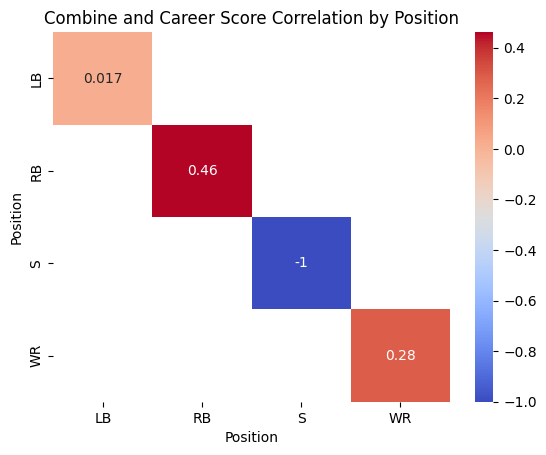

In [ ]:
def visual1():
    # Load the correlation table generated by the function
    corr_table = get_career_combine_score_correlation()

    # Create a pivot table with the correlation values for each position
    heatmap_data = corr_table.pivot_table(index="Position", columns="Position", values="Combine and Career Score Correlation", aggfunc=np.mean)

    # Create the heatmap with the data
    ax = sns.heatmap(heatmap_data, annot=True, cmap="coolwarm")

    # Customize the plot
    plt.title("Combine and Career Score Correlation by Position")
    plt.xlabel("Position")
    plt.ylabel("Position")


visual1()

### Visualization 1 Explanation

This visualizations shows our first insight. The correlations between combine score and career success can be seen for each position, and each correlation is color coded with deeper red being a stronger correlation and blue being smaller (more negative) correlation. This showws the conclusions gained from insight 1 in that that the NFL success of RBs and WRs are most strongly predicted by the NFL combine, while the NFL success of Ss is actually opposite of the combine results.

In [44]:
def visual2():
    d1 = get_topFive_combine()

    Position = widgets.Dropdown(options=['QB', 'WR', 'RB', 'LB', 'S'], value='QB')

    def f(Position):
        try:
            display(wait=True)
            if Position != '':
                df = pd.DataFrame(data=d1, columns=[Position, f'{Position}_score'])
            else:
                df = pd.DataFrame(data=None)

            fig = sns.barplot(
                x=df[Position],
                y=df[f'{Position}_score'],
                data=df
            )
            fig.set_xlabel('Name')
            fig.set_ylabel('Combine Score')
            fig.set_title(f'Combine Score ({Position})')
            ymin = df[f'{Position}_score'].min() - 1
            ymax = df[f'{Position}_score'].max()
            fig.set_ylim(ymin, ymax)
            fig.set_xticklabels(fig.get_xticklabels(), rotation=18, size=9)
            plt.show()

        except Exception as e:
            print(e)

    interact(f, Position=Position)


############ Function Call ############
visual2()

interactive(children=(Dropdown(description='Position', options=('QB', 'WR', 'RB', 'LB', 'S'), value='QB'), Out…

### Visualization 2 Explanation

This interactive visualization shows the combine score of the top five combine performers for each position. From the dropdown menu, you can select which position you are interested in. Once a position is selected, the bar plot will automatically update to show that names and career scores of the top five performers of that position in the 2018 NFL combine. The range of the y-axis also adjusts to better fit the data of that position. When looking at Ss, the fact that none of the top five combine performers have been successful in the NFL confirms our results from the first insight.

In [45]:
def visual3():
  df = pd.read_csv('clean_combine_data.csv', header=0)
  numeric_cols = ['40 Yard Dash', 'Vertical Leap', 'Broad Jump', 'Shuttle', '3Cone', 'Bench Press']
  for col in numeric_cols:
      df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)

  sns.set_style("whitegrid")
  metrics_dropdown = Dropdown(options=numeric_cols, description='Metric:')
    
  def update_plot(metric):
    clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    sns.boxplot(x="position", y=metric, data=df, palette="Set2", hue="position")
    plt.title(metric + ' Boxplot by Position')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.show()
    
  interact(update_plot, metric=metrics_dropdown)


visual3()

interactive(children=(Dropdown(description='Metric:', options=('40 Yard Dash', 'Vertical Leap', 'Broad Jump', …

### Visualization 3 Explanation

This interactive visual shows box plots for each combine drill and each position of interest. Using the dropdown menu, you can look at any drill you desire. The vertical leap is one of the best measures of overalll explosiveness. The median and 75th percentile of scores in this drill for WRs, RBs, and Ss are roughly the same, but Ss have by far the tightest distribution of scores. Interestingly, LBs and WRs have much wider ranges of scores in this drill. Since explosiveness is crucial to these positions, we would expect the scores of players who have made it to this stage in their football careers to have slightly more condensed distributions. These positions also represent good opportunities for athletes to really focus on the drill and wow at the top end of the distribution. The distribution for broad jump is similar to that of vertical leap. This result is intuitive since they are both designed to meaasure explosiveness from rest.

In [46]:
def create_touchdown_leaders_vis(percentile):
    clear_output(wait=True)  # clear the previous figure
    with open('clean_playerdata.csv') as f:
        # read in the cleaned player data and get a list of lists
        d1 = list(csv.reader(f))
        # convert the list of lists into a pandas dataframe
        df = pd.DataFrame(data=d1[1:], columns=d1[0])
        df['touchdowns'] = df['receiving_td'].astype(int) + df['rush_td'].astype(int)
        df.sort_values(by='touchdowns', ascending=False, inplace=True)
        df = df[df['touchdowns'] > 0]
        # calculate the threshold for the selected percentile
        threshold = int(df.shape[0] * (1 - percentile / 100))
        leaders = pd.DataFrame(data=df.iloc[:threshold], columns=['name', 'team', 'position', 'touchdowns'])
        leaders.reset_index(inplace=True, drop=True)
        
        # check if the leaders DataFrame is empty
        if leaders.empty:
            print(f"No data available for selected percentile ({percentile}%)")
            return
        
        # define a color map for each position
        position_colors = {'QB': 'red', 'WR': 'orange', 'RB': 'green', 'LB': 'blue', 'S': 'purple'}
        colors = leaders['position'].map(position_colors)
        
        # create a lollipop chart to show the touchdown leaders
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.hlines(y=leaders['name'], xmin=0, xmax=leaders['touchdowns'], color=colors)
        ax.scatter(leaders['touchdowns'], leaders['name'], color=colors)
        ax.set_xlabel('Touchdowns')
        ax.set_ylabel('Player Name')
        ax.set_title('Top Touchdown Scorers Since 2019')
        
        # create the legend
        handles = []
        labels = []
        for position, color in position_colors.items():
            handles.append(plt.Rectangle((0, 0), 1, 1, color=color))
            labels.append(position)
        ax.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
        
        plt.show()


# create the slider widget
percentile_slider = widgets.FloatSlider(min=50, max=100, step=1, value=90, description='Select Percentile')

# define the function to update the visualization when the slider value changes
def update_vis(percentile):
    create_touchdown_leaders_vis(percentile)

# create the interactive display
widgets.interact(update_vis, percentile=percentile_slider);

interactive(children=(FloatSlider(value=90.0, description='Select Percentile', min=50.0, step=1.0), Output()),…

### Visualization 4 Explanation

This interactive visual shows the top x percent of touchdown leaders of players that debuted in 2018, where x is a percentile chosen by the slider above the graph. As our touchdown leaders insight showed us, this graph confirms that the summary statistics in each players bio that appeared to represent their career statistics does not in fact represent their career statistics but rather their 2022 statistics. This visualization provides a visual showing of our results from insight 3, which provides some reference for understanding the scale of the player's scores.

# Cited Sources

If you used any additional sources to complete your Data Analysis section, list them here:


*   Using Display and clear_output from IPython.display (https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html)

*   Using FigureCanvasAgg from matplotlib.backends.backend_agg (https://matplotlib.org/stable/api/backend_agg_api.html)



# Graphical User Interface (GUI) Implementation
If you decide to create a GUI for Phase II, please create a separate Python file (.py) to build your GUI. You must submit both the completed PhaseII.ipynb and your Python GUI file.

For our project, we created a GUI that allows users to view career score data for all NFL players who debuted in 2018, including their receptions, receiving yards, receiving touchdowns, solo tackles, forced fumbles, interceptions, passes defended, rush yards, rush touchdowns, and sacks. The user can sort the data either by a player's name using the search bar at the top or by position using the drop-down menu at the top left. If you would like to view the code for our GUI, please refer to the "PhaseIII.py" file located inside the GUI folder. We have also attached a .gif of the visualization as part of our submission entitled graphical-user-interface.gif.

If you would like to run the GUI, please ensure that you run it in the GUI folder, as you need the clean_playerdata.csv file. To run the GUI, execute the following command:

```
python PhaseIII.py
```



# Submission

Prior to submitting your notebook to Gradescope, be sure to <b>run all functions within this file</b>. We will not run your functions ourselves, so we must see your outputs within this file in order to receive full credit.
